# NFL Big Data Bowl 2026 - Data Exploration (UPDATED)

This notebook explores the actual competition data structure.

**Key insight**: The data shows player positions at the moment the ball is thrown,
and we know where the ball will land (`ball_land_x`, `ball_land_y`).

**Goal**: Analyze how players move toward/away from the ball landing spot.

## Setup and Imports

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Imports successful!")

✅ Imports successful!


## Load Data

In [34]:
# Define paths
DATA_DIR = Path('../data')
COMPETITION_DIR = DATA_DIR / '114239_nfl_competition_files_published_analytics_final'
TRAIN_DIR = COMPETITION_DIR / 'train'

# Load supplementary data
print("Loading supplementary data...")
supp_data = pd.read_csv(COMPETITION_DIR / 'supplementary_data.csv')
print(f"✓ Loaded: {len(supp_data):,} rows")

# Load Week 2 INPUT data (moment ball is thrown)
print("\nLoading Week 2 input data...")
input_w02 = pd.read_csv(TRAIN_DIR / 'input_2023_w02.csv')
print(f"✓ Loaded: {len(input_w02):,} rows")

# Load Week 2 OUTPUT data (player positions after ball is thrown)
print("\nLoading Week 2 output data...")
output_w02 = pd.read_csv(TRAIN_DIR / 'output_2023_w02.csv')
print(f"✓ Loaded: {len(output_w02):,} rows")

print("\n✅ Data loaded successfully!")

Loading supplementary data...
✓ Loaded: 18,009 rows

Loading Week 2 input data...
✓ Loaded: 288,586 rows

Loading Week 2 output data...
✓ Loaded: 32,180 rows

✅ Data loaded successfully!


## 1. Understanding the Data Structure

In [35]:
print("="*80)
print("INPUT DATA (Moment Ball is Thrown)")
print("="*80)
print(f"\nShape: {input_w02.shape}")
print(f"\nColumns ({len(input_w02.columns)}):")
for col in input_w02.columns:
    print(f"  • {col}")

print("\n" + "="*80)
print("First few rows:")
print("="*80)
input_w02.head()

INPUT DATA (Moment Ball is Thrown)

Shape: (288586, 23)

Columns (23):
  • game_id
  • play_id
  • player_to_predict
  • nfl_id
  • frame_id
  • play_direction
  • absolute_yardline_number
  • player_name
  • player_height
  • player_weight
  • player_birth_date
  • player_position
  • player_side
  • player_role
  • x
  • y
  • s
  • a
  • dir
  • o
  • num_frames_output
  • ball_land_x
  • ball_land_y

First few rows:


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023091400,56,False,54583,1,left,85,Akayleb Evans,6-2,193,1999-06-22,CB,Defense,Defensive Coverage,78.78,13.43,0.24,0.25,105.26,64.25,10,81.809998,36.77
1,2023091400,56,False,54583,2,left,85,Akayleb Evans,6-2,193,1999-06-22,CB,Defense,Defensive Coverage,78.80,13.42,0.20,0.41,107.29,65.30,10,81.809998,36.77
2,2023091400,56,False,54583,3,left,85,Akayleb Evans,6-2,193,1999-06-22,CB,Defense,Defensive Coverage,78.82,13.41,0.14,0.53,106.83,64.31,10,81.809998,36.77
3,2023091400,56,False,54583,4,left,85,Akayleb Evans,6-2,193,1999-06-22,CB,Defense,Defensive Coverage,78.83,13.41,0.08,0.57,103.10,64.31,10,81.809998,36.77
4,2023091400,56,False,54583,5,left,85,Akayleb Evans,6-2,193,1999-06-22,CB,Defense,Defensive Coverage,78.83,13.40,0.07,0.53,162.75,67.19,10,81.809998,36.77


In [36]:
print("="*80)
print("OUTPUT DATA (Player Movement After Throw)")
print("="*80)
print(f"\nShape: {output_w02.shape}")
print(f"\nColumns ({len(output_w02.columns)}):")
for col in output_w02.columns:
    print(f"  • {col}")

print("\n" + "="*80)
print("First few rows:")
print("="*80)
output_w02.head(10)

OUTPUT DATA (Player Movement After Throw)

Shape: (32180, 6)

Columns (6):
  • game_id
  • play_id
  • nfl_id
  • frame_id
  • x
  • y

First few rows:


,game_id,play_id,nfl_id,frame_id,x,y
0,2023091400,56,47816,1,75.81,44.50
1,2023091400,56,47816,2,75.75,44.37
2,2023091400,56,47816,3,75.72,44.20
3,2023091400,56,47816,4,75.77,43.99
4,2023091400,56,47816,5,75.87,43.74
5,2023091400,56,47816,6,76.03,43.45
6,2023091400,56,47816,7,76.23,43.13
7,2023091400,56,47816,8,76.49,42.77
8,2023091400,56,47816,9,76.78,42.38
9,2023091400,56,47816,10,77.10,41.98


## 2. Key Insights About Data Structure

**INPUT data** = Snapshot at moment ball is thrown (frameId = 1)
**OUTPUT data** = Player positions in frames AFTER throw (frameId > 1)

We can combine these to see complete player movement!

In [40]:
# Check unique values for key columns
print("INPUT DATA Summary:")
print("="*80)
print(f"Unique games: {input_w02['game_id'].nunique()}")
print(f"Unique plays: {input_w02['play_id'].nunique()}")
print(f"Unique players: {input_w02['nfl_id'].nunique()}")
print(f"Frame IDs: {sorted(input_w02['frame_id'].unique())}")

print("\nPlayer Roles:")
print(input_w02['player_role'].value_counts())

print("\nPlayer Sides:")
print(input_w02['player_side'].value_counts())

print("\nPlayer Positions (16 total for week 02):")
print(input_w02['player_position'].value_counts().head(16))

INPUT DATA Summary:
Unique games: 16
Unique plays: 777
Unique players: 746
Frame IDs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63)]

Player Roles:
player_role
Defensive Cov

In [42]:
print("\nOUTPUT DATA Summary:")
print("="*80)
print(f"Frame IDs range: {output_w02['frame_id'].min()} to {output_w02['frame_id'].max()}")
print(f"\nFrames per play (typical for week 02): {output_w02.groupby(['game_id', 'play_id', 'nfl_id'])['frame_id'].nunique().mean():.1f}")


OUTPUT DATA Summary:
Frame IDs range: 1 to 40

Frames per play (typical for week 02): 11.7


## 3. Analyze Single Play in Detail

In [70]:
# Get first play from input data
first_game = input_w02['game_id'].iloc[-1]
first_play = input_w02['play_id'].iloc[-1]

# Extract input (frame 1 - moment of throw)
play_input = input_w02[
    (input_w02['game_id'] == first_game) & 
    (input_w02['play_id'] == first_play)
].copy()

# Extract output (frames 2+ - after throw)
play_output = output_w02[
    (output_w02['game_id'] == first_game) & 
    (output_w02['play_id'] == first_play)
].copy()

print(f"Game ID: {first_game}")
print(f"Play ID: {first_play}")
print(f"\nINPUT (moment of throw):")
print(f"  Players tracked: {len(play_input)}")
print(f"\nOUTPUT (after throw):")
print(f"  Total tracking points: {len(play_output)}")
print(f"  Frames: {play_output['frame_id'].nunique()}")
print(f"  Players tracked: {play_output['nfl_id'].nunique()}")

# Get ball landing location
ball_land_x = play_input['ball_land_x'].iloc[0]
ball_land_y = play_input['ball_land_y'].iloc[0]
print(f"\nBall landing location: (x:{ball_land_x:.1f}, y:{ball_land_y:.1f})")

Game ID: 2023091801
Play ID: 4431

INPUT (moment of throw):
  Players tracked: 403

OUTPUT (after throw):
  Total tracking points: 44
  Frames: 11
  Players tracked: 4

Ball landing location: (x:56.5, y:15.1)


In [71]:
# Look at player roles in this play
print("Player roles in this play:")
print("="*80)
print(play_input['player_role'].value_counts())

print("\nTargeted Receiver:")
target = play_input[play_input['player_role'] == 'Targeted Receiver']
if len(target) > 0:
    print(f"  Position: {target['player_position'].iloc[0]}")
    print(f"  Starting location: ({target['x'].iloc[0]:.1f}, {target['y'].iloc[0]:.1f})")
    print(f"  Speed: {target['s'].iloc[0]:.2f} yards/sec")

Player roles in this play:
player_role
Defensive Coverage    217
Other Route Runner    124
Passer                 31
Targeted Receiver      31
Name: count, dtype: int64

Targeted Receiver:
  Position: WR
  Starting location: (43.8, 19.2)
  Speed: 0.04 yards/sec


## 4. Combine Input and Output for Complete View

In [72]:
# Combine input and output to see complete player movement
# Input is frame 1, output is frames 2+
play_complete = pd.concat([play_input, play_output], ignore_index=True)
play_complete = play_complete.sort_values(['nfl_id', 'frame_id'])

print(f"Complete play data: {len(play_complete)} rows")
print(f"Frames: {sorted(play_complete['frame_id'].unique())}")
print(f"\nThis represents the complete movement from throw to catch/incompletion!")

Complete play data: 447 rows
Frames: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31)]

This represents the complete movement from throw to catch/incompletion!


## 5. Visualize the Play

In [73]:
def plot_play_frame(play_df, frame_id, ball_land_x, ball_land_y, title=""):
    """
    Plot player positions for a single frame
    """
    frame_data = play_df[play_df['frame_id'] == frame_id]
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Draw field boundaries
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_xlabel('X Position (yards)', fontsize=12)
    ax.set_ylabel('Y Position (yards)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add yard lines
    for yard in range(10, 111, 10):
        ax.axvline(yard, color='lightgray', linestyle='--', alpha=0.5, linewidth=0.5)
    
    # Plot ball landing spot
    ax.scatter(ball_land_x, ball_land_y, 
              c='gold', s=500, marker='*', 
              edgecolors='black', linewidth=2, 
              label='Ball Landing Spot', zorder=10)
    
    # Plot players by side
    offense = frame_data[frame_data['player_side'] == 'Offense']
    defense = frame_data[frame_data['player_side'] == 'Defense']
    
    # Plot offense
    ax.scatter(offense['x'], offense['y'], 
              c='blue', s=200, alpha=0.7, 
              edgecolors='black', linewidth=1.5,
              label='Offense')
    
    # Highlight targeted receiver
    target = frame_data[frame_data['player_role'] == 'Targeted Receiver']
    if len(target) > 0:
        ax.scatter(target['x'], target['y'], 
                  c='darkblue', s=300, alpha=0.9, 
                  edgecolors='yellow', linewidth=3,
                  label='Target', zorder=5)
    
    # Plot defense
    ax.scatter(defense['x'], defense['y'], 
              c='red', s=200, alpha=0.7, 
              edgecolors='black', linewidth=1.5,
              label='Defense')
    
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    return fig, ax

print("✅ Plotting function defined")

✅ Plotting function defined


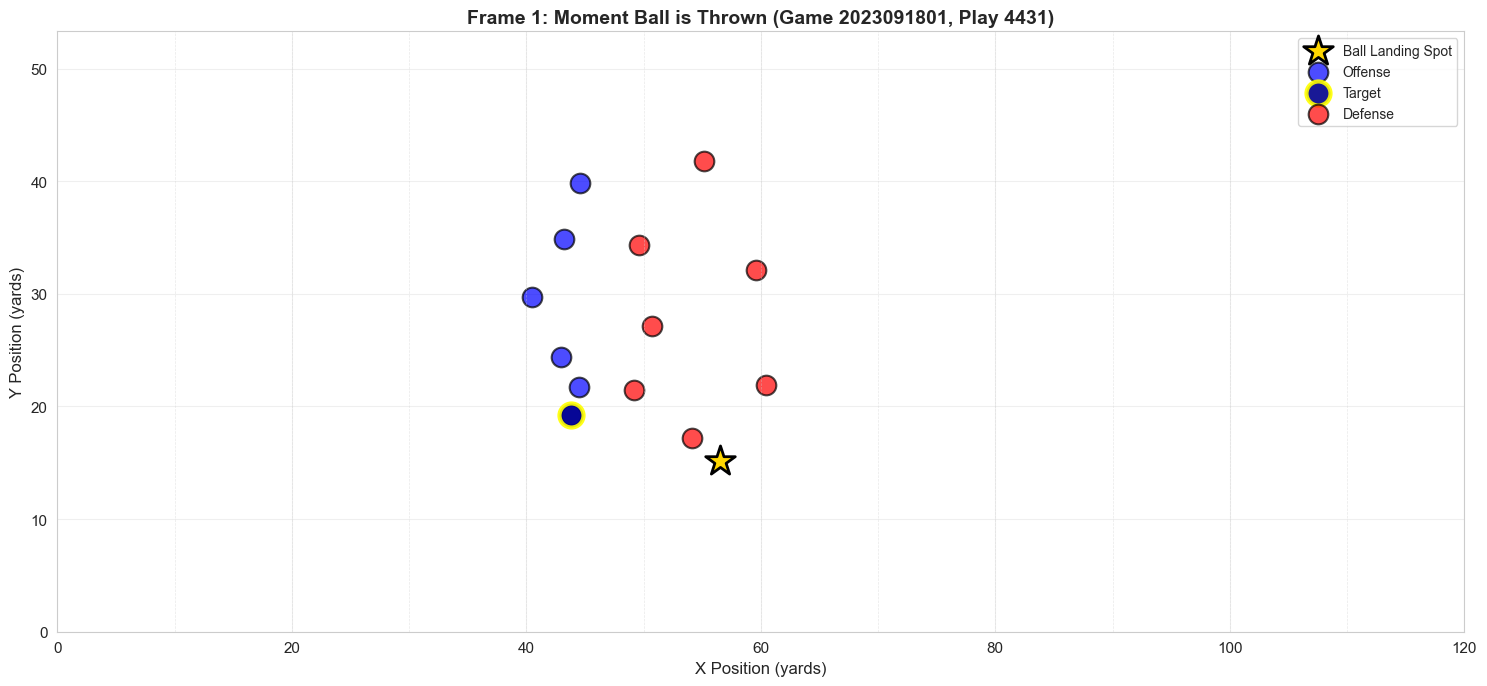

In [74]:
# Plot frame 1 (moment ball is thrown)
plot_play_frame(
    play_complete, 
    1,
    ball_land_x,
    ball_land_y,
    f"Frame 1: Moment Ball is Thrown (Game {first_game}, Play {first_play})"
)
plt.show()

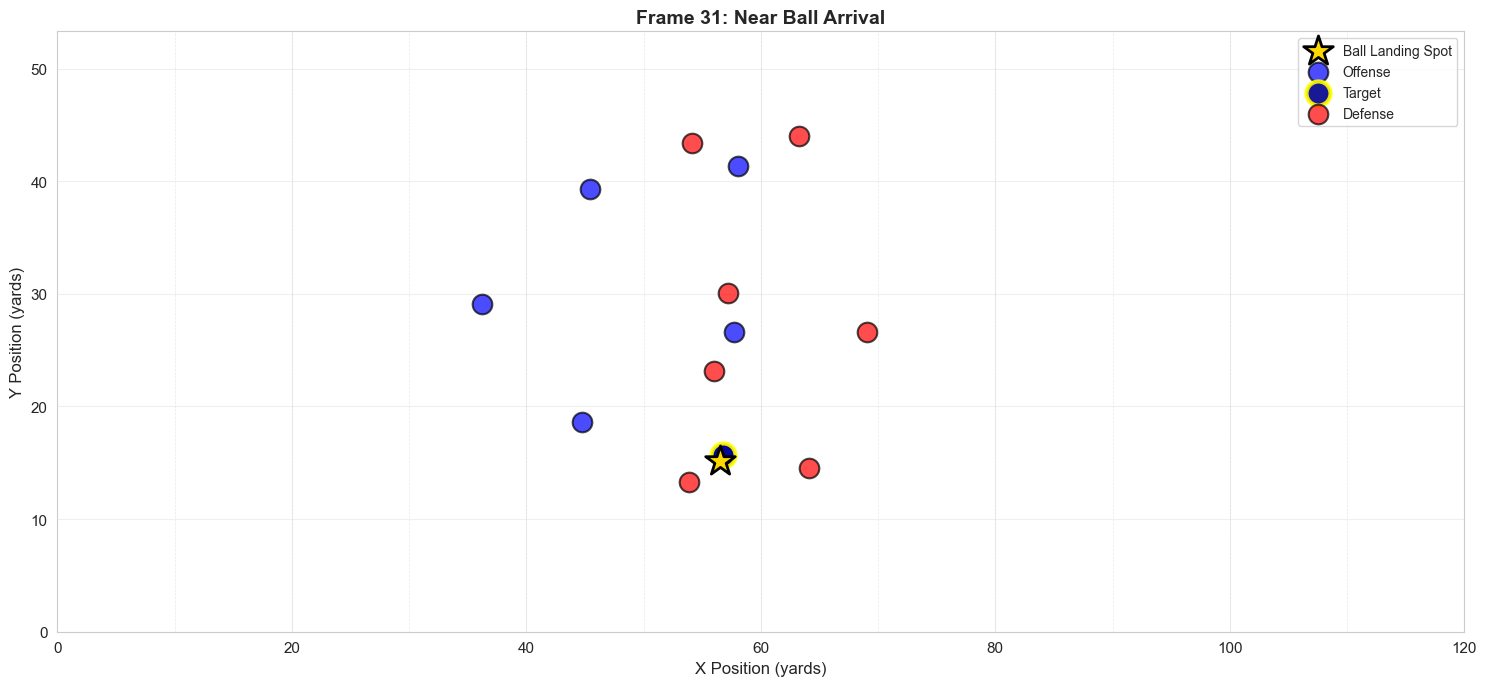

In [75]:
# Plot final frame (near catch/incompletion)
final_frame = play_complete['frame_id'].max()
plot_play_frame(
    play_complete, 
    final_frame,
    ball_land_x,
    ball_land_y,
    f"Frame {final_frame}: Near Ball Arrival"
)
plt.show()

## 6. Create Player Trajectory Visualization

In [76]:
def plot_player_trajectories(play_df, ball_land_x, ball_land_y):
    """
    Plot movement paths for all players
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Field setup
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_xlabel('X Position (yards)', fontsize=12)
    ax.set_ylabel('Y Position (yards)', fontsize=12)
    ax.set_title('Player Trajectories While Ball is in Air', fontsize=14, fontweight='bold')
    
    # Yard lines
    for yard in range(10, 111, 10):
        ax.axvline(yard, color='lightgray', linestyle='--', alpha=0.3, linewidth=0.5)
    
    # Plot ball landing spot
    ax.scatter(ball_land_x, ball_land_y, 
              c='gold', s=600, marker='*', 
              edgecolors='black', linewidth=3, 
              label='Ball Landing', zorder=15)
    
    # Plot trajectories by side
    offense = play_df[play_df['player_side'] == 'Offense']
    defense = play_df[play_df['player_side'] == 'Defense']
    
    # Offense trajectories
    for player_id in offense['nfl_id'].unique():
        player_data = offense[offense['nfl_id'] == player_id].sort_values('frame_id')
        
        if len(player_data) > 1:
            is_target = (player_data['player_role'] == 'Targeted Receiver').any()
            
            if is_target:
                ax.plot(player_data['x'], player_data['y'], 
                       '-', color='darkblue', alpha=0.9, linewidth=3, zorder=10)
                ax.scatter(player_data['x'].iloc[-1], player_data['y'].iloc[-1],
                         color='darkblue', s=200, marker='s', 
                         edgecolors='yellow', linewidth=3, zorder=10)
            else:
                ax.plot(player_data['x'], player_data['y'], 
                       '-', color='blue', alpha=0.3, linewidth=1.5)
                ax.scatter(player_data['x'].iloc[-1], player_data['y'].iloc[-1],
                         color='blue', s=100, alpha=0.5, marker='s', 
                         edgecolors='black')
    
    # Defense trajectories
    for player_id in defense['nfl_id'].unique():
        player_data = defense[defense['nfl_id'] == player_id].sort_values('frame_id')
        
        if len(player_data) > 1:
            ax.plot(player_data['x'], player_data['y'], 
                   '-', color='red', alpha=0.4, linewidth=1.5)
            ax.scatter(player_data['x'].iloc[-1], player_data['y'].iloc[-1],
                     color='red', s=100, alpha=0.6, marker='s', 
                     edgecolors='black')
    
    # Custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='darkblue', linewidth=3, label='Target Receiver'),
        Line2D([0], [0], color='blue', linewidth=2, alpha=0.5, label='Other Offense'),
        Line2D([0], [0], color='red', linewidth=2, alpha=0.5, label='Defense'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', 
               markersize=15, label='Ball Landing')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    return fig, ax

print("✅ Trajectory plotting function defined")

✅ Trajectory plotting function defined


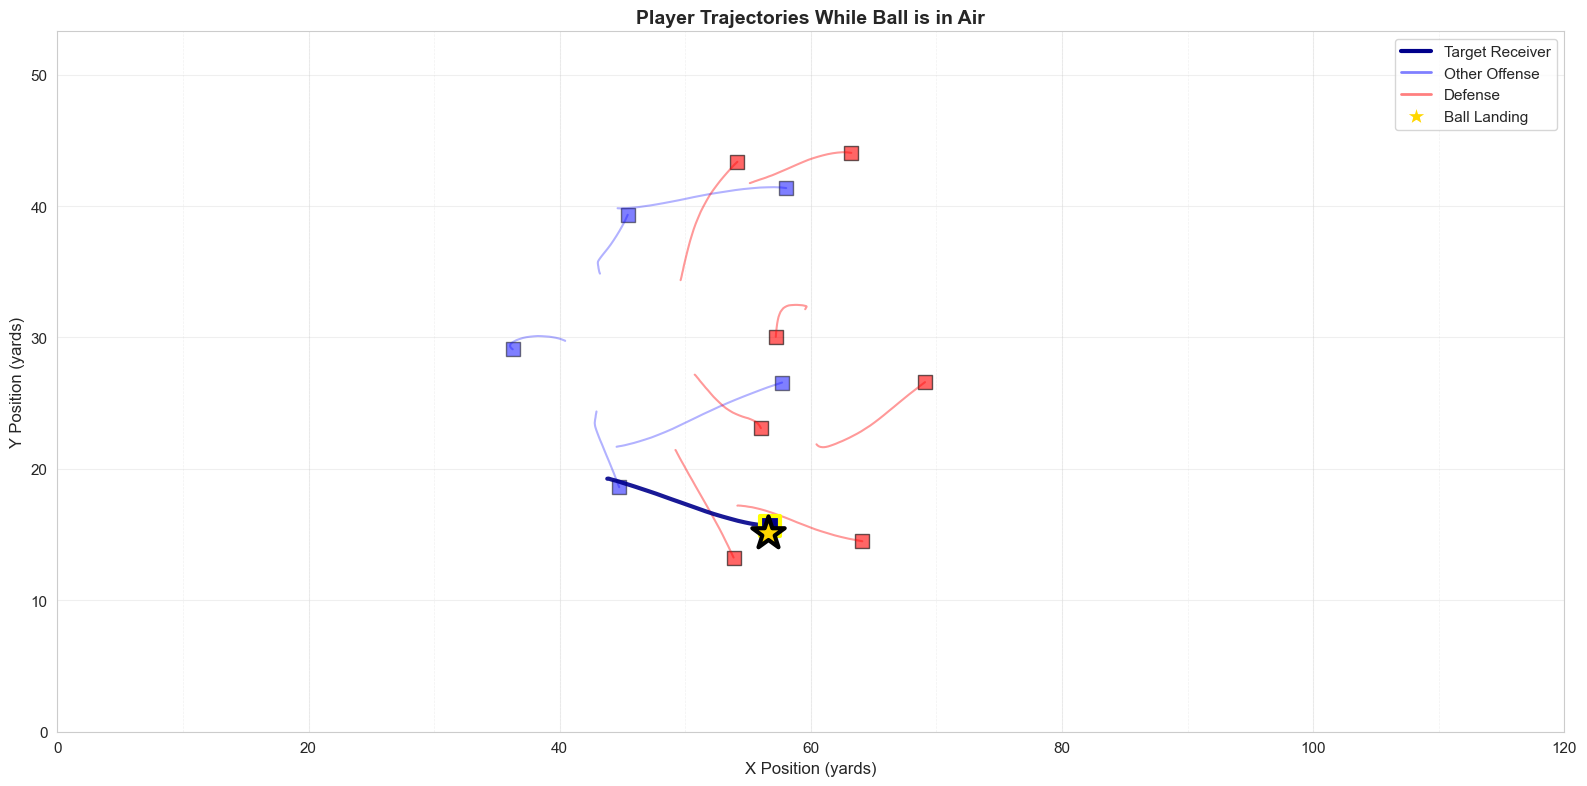

In [77]:
# Plot trajectories for our sample play
plot_player_trajectories(play_complete, ball_land_x, ball_land_y)
plt.show()

## 7. Calculate Distance to Ball Landing Spot

This is KEY - we know where the ball will land!

In [78]:
def calculate_distance_to_landing(play_df, ball_land_x, ball_land_y):
    """
    Calculate each player's distance to ball landing spot
    """
    play_df = play_df.copy()
    play_df['dist_to_landing'] = np.sqrt(
        (play_df['x'] - ball_land_x)**2 + 
        (play_df['y'] - ball_land_y)**2
    )
    return play_df

# Calculate for our play
play_with_dist = calculate_distance_to_landing(play_complete, ball_land_x, ball_land_y)

print("Distance to Landing Spot Statistics:")
print("="*80)
print(f"Mean distance: {play_with_dist['dist_to_landing'].mean():.2f} yards")
print(f"Min distance: {play_with_dist['dist_to_landing'].min():.2f} yards")
print(f"Max distance: {play_with_dist['dist_to_landing'].max():.2f} yards")

Distance to Landing Spot Statistics:
Mean distance: 15.14 yards
Min distance: 0.56 yards
Max distance: 29.70 yards


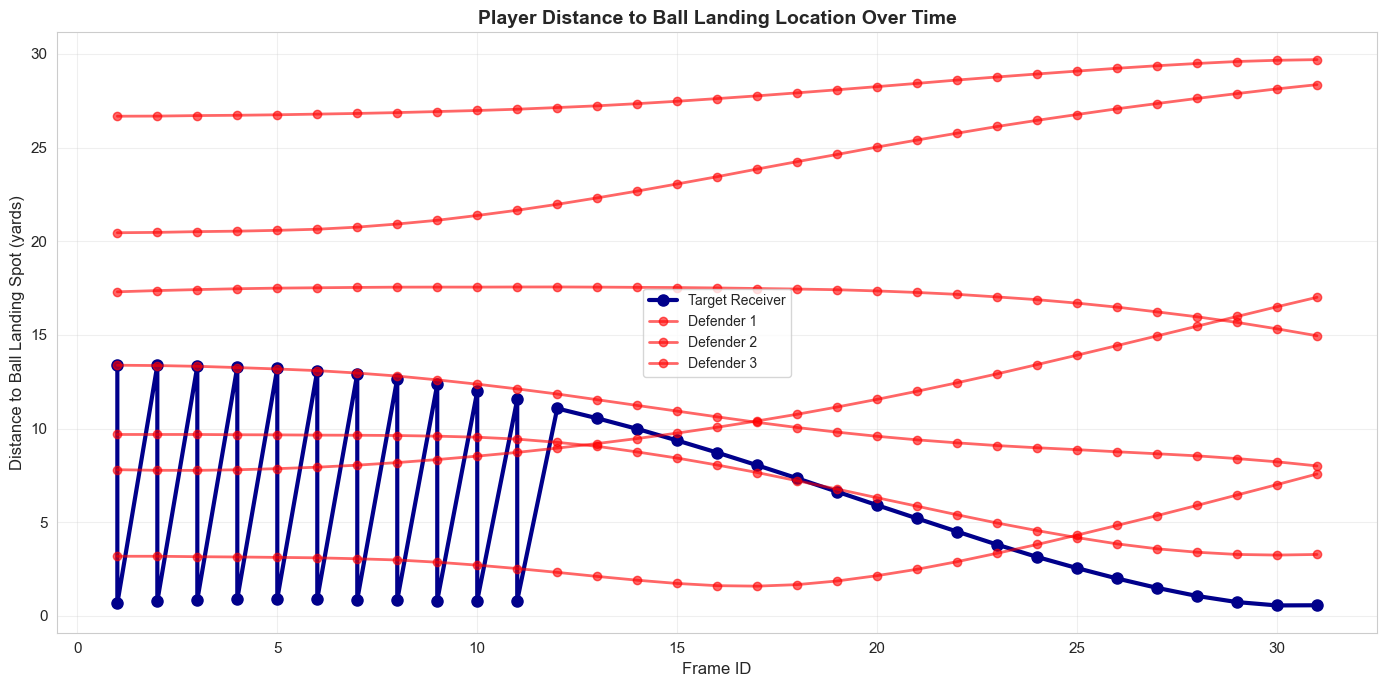

In [79]:
# Analyze how distance changes over time for key players
# Get target receiver
target_player = play_with_dist[play_with_dist['player_role'] == 'Targeted Receiver']['nfl_id'].iloc[0]

# Get defensive coverage players
coverage = play_with_dist[play_with_dist['player_role'] == 'Defensive Coverage']

plt.figure(figsize=(14, 7))

# Plot target receiver distance
target_data = play_with_dist[play_with_dist['nfl_id'] == target_player].sort_values('frame_id')
plt.plot(target_data['frame_id'], target_data['dist_to_landing'],
         'o-', color='darkblue', linewidth=3, markersize=8,
         label='Target Receiver')

# Plot defensive coverage distances
for i, (player_id, group) in enumerate(coverage.groupby('nfl_id')):
    group = group.sort_values('frame_id')
    if len(group) > 1:  # Only plot if we have trajectory
        plt.plot(group['frame_id'], group['dist_to_landing'],
                'o-', color='red', alpha=0.6, linewidth=2, markersize=6,
                label=f'Defender {i+1}' if i < 3 else '')

plt.xlabel('Frame ID', fontsize=12)
plt.ylabel('Distance to Ball Landing Spot (yards)', fontsize=12)
plt.title('Player Distance to Ball Landing Location Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Analyze Convergence Rate

How quickly do defenders close in on the landing spot?

In [80]:
def calculate_convergence_rate(player_distances_df):
    """
    Calculate rate of distance change (negative = moving closer)
    """
    player_distances_df = player_distances_df.sort_values('frame_id')
    
    # Calculate distance change per frame
    player_distances_df['dist_change'] = player_distances_df['dist_to_landing'].diff()
    
    # Convergence rate (yards per frame, negative = closing in)
    player_distances_df['convergence_rate'] = -player_distances_df['dist_change'] * 10  # Convert to yards/second
    
    return player_distances_df

# Calculate for all players
play_with_convergence = play_with_dist.copy()
play_with_convergence = play_with_convergence.groupby('nfl_id', group_keys=False).apply(
    calculate_convergence_rate
)

# Analyze convergence rates
print("Convergence Rate Statistics:")
print("="*80)
print("(Positive = moving toward ball, Negative = moving away)\n")

for role in ['Targeted Receiver', 'Defensive Coverage']:
    role_data = play_with_convergence[play_with_convergence['player_role'] == role]
    if len(role_data) > 0:
        print(f"{role}:")
        print(f"  Mean convergence rate: {role_data['convergence_rate'].mean():.2f} yards/sec")
        print(f"  Max convergence rate: {role_data['convergence_rate'].max():.2f} yards/sec")
        print()

Convergence Rate Statistics:
(Positive = moving toward ball, Negative = moving away)

Targeted Receiver:
  Mean convergence rate: -39.72 yards/sec
  Max convergence rate: 7.18 yards/sec

Defensive Coverage:
  Mean convergence rate: -3.64 yards/sec
  Max convergence rate: 102.40 yards/sec



## 9. Explore Multiple Plays

In [81]:
# Get summary statistics for all plays in Week 2
print("Week 2 Data Summary:")
print("="*80)
print(f"Total unique plays: {input_w02.groupby(['game_id', 'play_id']).ngroups}")
print(f"Total games: {input_w02['game_id'].nunique()}")
print(f"\nPlayers per play statistics:")
players_per_play = input_w02.groupby(['game_id', 'play_id']).size()
print(f"  Mean: {players_per_play.mean():.1f}")
print(f"  Min: {players_per_play.min()}")
print(f"  Max: {players_per_play.max()}")

Week 2 Data Summary:
Total unique plays: 850
Total games: 16

Players per play statistics:
  Mean: 339.5
  Min: 80
  Max: 826



Player Role Distribution (all Week 2 plays):
player_role
Defensive Coverage    157105
Other Route Runner     84875
Passer                 23303
Targeted Receiver      23303
Name: count, dtype: int64


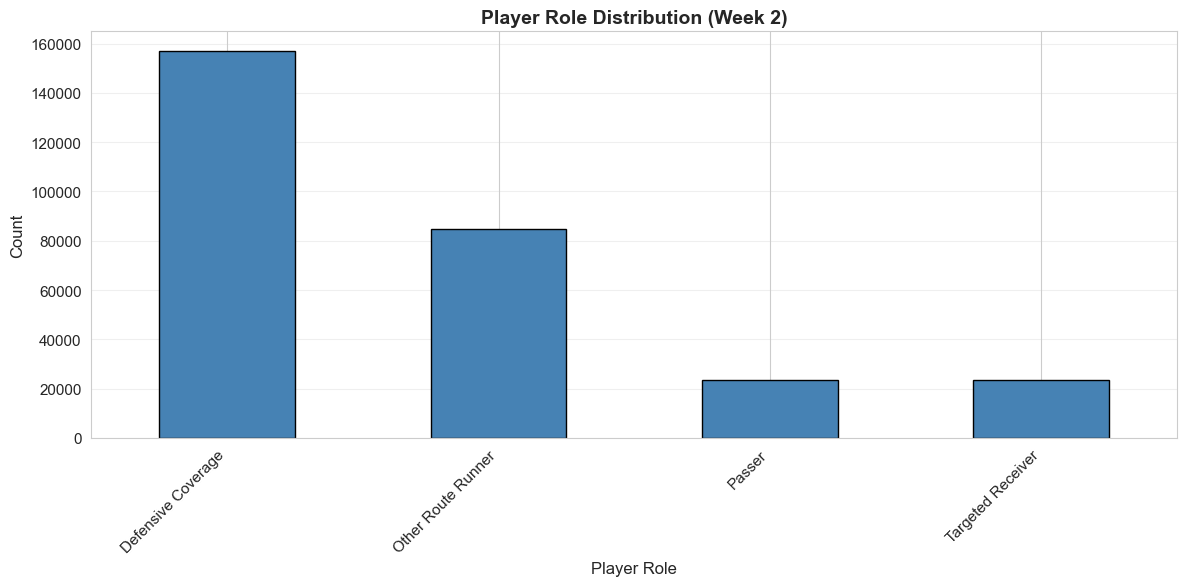

In [82]:
# Analyze player roles across all plays
print("\nPlayer Role Distribution (all Week 2 plays):")
print("="*80)
role_counts = input_w02['player_role'].value_counts()
print(role_counts)

# Visualize
plt.figure(figsize=(12, 6))
role_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Player Role', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Player Role Distribution (Week 2)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


Player Position Distribution (all Week 2 plays):
player_position
WR     62435
CB     60422
FS     32854
TE     25363
QB     23463
SS     19789
RB     18952
ILB    17863
MLB    12885
OLB    11517
FB      1219
DE      1120
S        484
DT       150
T         49
Name: count, dtype: int64


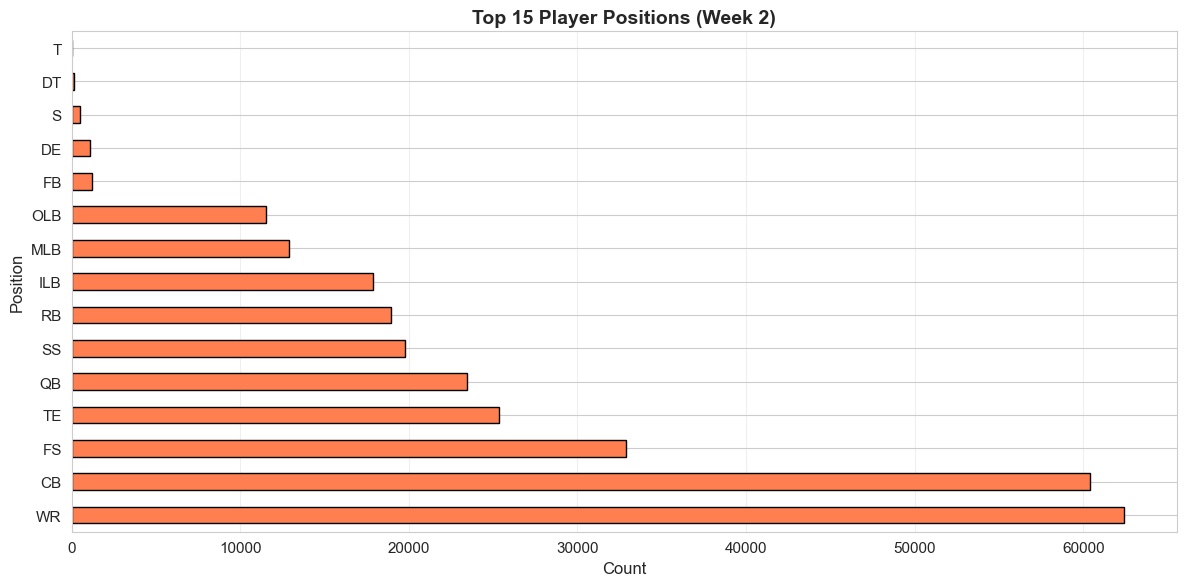

In [83]:
# Analyze player positions
print("\nPlayer Position Distribution (all Week 2 plays):")
print("="*80)
position_counts = input_w02['player_position'].value_counts().head(15)
print(position_counts)

# Visualize
plt.figure(figsize=(12, 6))
position_counts.plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.title('Top 15 Player Positions (Week 2)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 10. Analyze Ball Landing Patterns

In [84]:
# Get unique plays with ball landing locations
unique_plays = input_w02.groupby(['game_id', 'play_id']).first()[['ball_land_x', 'ball_land_y']].reset_index()

print(f"Total plays with ball landing data: {len(unique_plays)}")
print(f"\nBall landing X (yards from end zone):")
print(f"  Mean: {unique_plays['ball_land_x'].mean():.1f}")
print(f"  Min: {unique_plays['ball_land_x'].min():.1f}")
print(f"  Max: {unique_plays['ball_land_x'].max():.1f}")
print(f"\nBall landing Y (yards from sideline):")
print(f"  Mean: {unique_plays['ball_land_y'].mean():.1f}")
print(f"  Min: {unique_plays['ball_land_y'].min():.1f}")
print(f"  Max: {unique_plays['ball_land_y'].max():.1f}")

Total plays with ball landing data: 850

Ball landing X (yards from end zone):
  Mean: 60.6
  Min: -0.4
  Max: 118.4

Ball landing Y (yards from sideline):
  Mean: 26.1
  Min: -1.7
  Max: 56.0


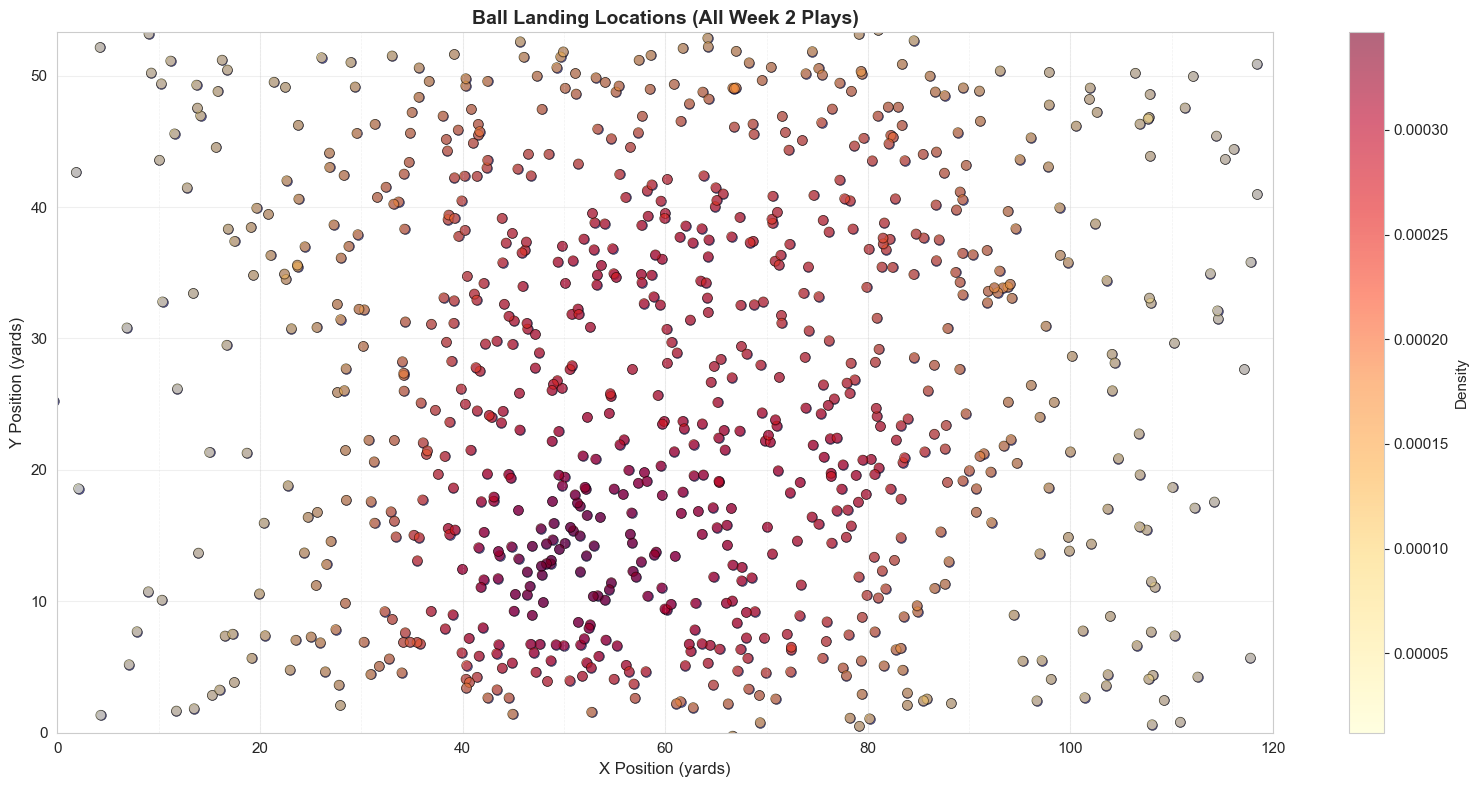

In [85]:
# Visualize ball landing locations
fig, ax = plt.subplots(figsize=(16, 8))

# Draw field
ax.set_xlim(0, 120)
ax.set_ylim(0, 53.3)
ax.set_xlabel('X Position (yards)', fontsize=12)
ax.set_ylabel('Y Position (yards)', fontsize=12)
ax.set_title('Ball Landing Locations (All Week 2 Plays)', fontsize=14, fontweight='bold')

# Yard lines
for yard in range(10, 111, 10):
    ax.axvline(yard, color='lightgray', linestyle='--', alpha=0.3, linewidth=0.5)

# Plot all landing locations
scatter = ax.scatter(unique_plays['ball_land_x'], unique_plays['ball_land_y'],
                    c='darkblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# Add heatmap overlay
from scipy.stats import gaussian_kde
xy = np.vstack([unique_plays['ball_land_x'], unique_plays['ball_land_y']])
z = gaussian_kde(xy)(xy)

scatter = ax.scatter(unique_plays['ball_land_x'], unique_plays['ball_land_y'],
                    c=z, s=50, cmap='YlOrRd', alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Density', ax=ax)

ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Speed and Acceleration Analysis

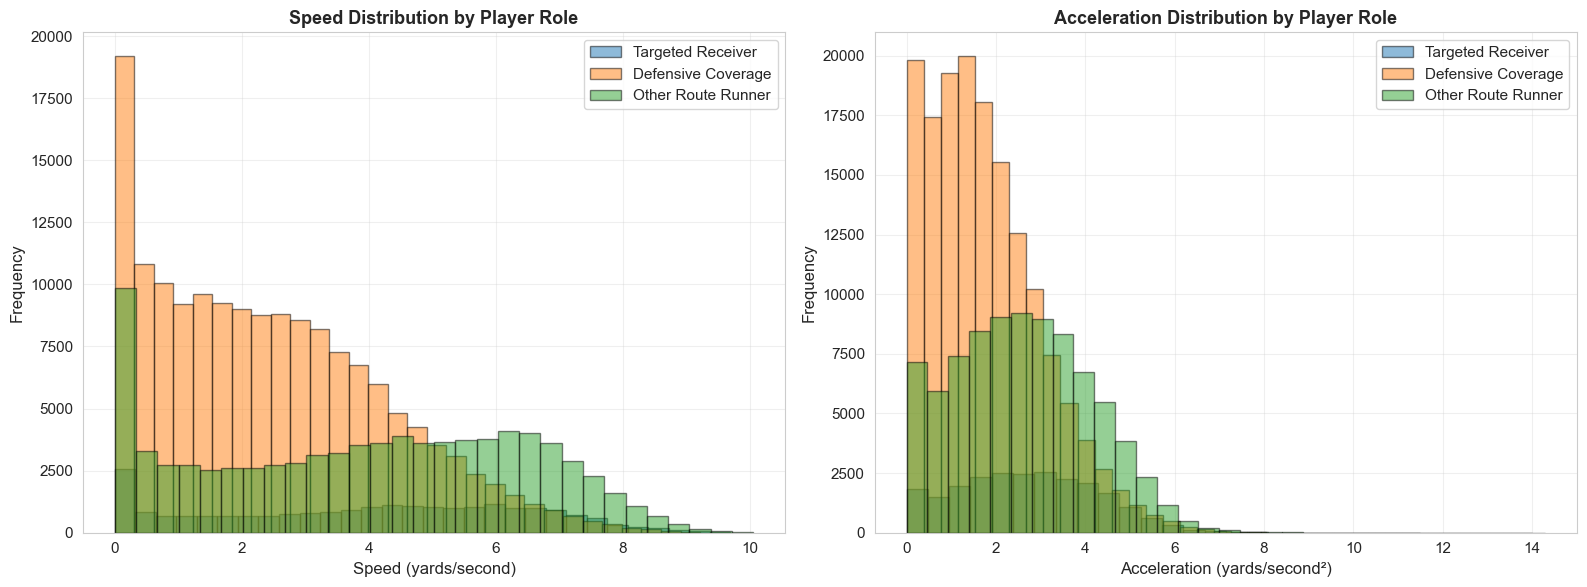

In [61]:
# Compare speeds by player role
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Speed distribution
for role in ['Targeted Receiver', 'Defensive Coverage', 'Other Route Runner']:
    role_data = input_w02[input_w02['player_role'] == role]
    if len(role_data) > 0:
        axes[0].hist(role_data['s'], bins=30, alpha=0.5, label=role, edgecolor='black')

axes[0].set_xlabel('Speed (yards/second)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Speed Distribution by Player Role', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Acceleration distribution
for role in ['Targeted Receiver', 'Defensive Coverage', 'Other Route Runner']:
    role_data = input_w02[input_w02['player_role'] == role]
    if len(role_data) > 0:
        axes[1].hist(role_data['a'], bins=30, alpha=0.5, label=role, edgecolor='black')

axes[1].set_xlabel('Acceleration (yards/second²)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Acceleration Distribution by Player Role', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [62]:
# Statistical summary by role
print("Speed & Acceleration Statistics by Player Role:")
print("="*80)

summary = input_w02.groupby('player_role')[['s', 'a']].agg(['mean', 'std', 'min', 'max'])
print(summary.round(2))

Speed & Acceleration Statistics by Player Role:
                       s                       a                  
                    mean   std  min    max  mean   std  min    max
player_role                                                       
Defensive Coverage  2.44  1.81  0.0   9.22  1.77  1.26  0.0  11.48
Other Route Runner  3.90  2.49  0.0  10.06  2.61  1.51  0.0  14.00
Passer              1.73  1.52  0.0   8.61  1.88  1.26  0.0   9.91
Targeted Receiver   3.95  2.45  0.0   9.70  2.72  1.54  0.0  14.29


## 12. Identify Potential Metrics to Create

Based on the data structure, here are promising analysis directions...

In [63]:
print("="*80)
print("POTENTIAL METRICS FOR ANALYTICS TRACK")
print("="*80)

print("""
Based on this data structure, here are excellent metric ideas:

1. DEFENSIVE CONVERGENCE METRICS:
   ✓ Convergence Speed: How fast defenders close on ball landing spot
   ✓ Reaction Time: How quickly defenders change direction after throw
   ✓ Convergence Coordination: How well multiple defenders converge together
   ✓ Optimal Positioning Score: Distance from landing spot at key frames

2. RECEIVER METRICS:
   ✓ Route Efficiency: Direct path vs actual path to landing spot
   ✓ Adjustment Ability: How quickly receiver adjusts to ball location
   ✓ Separation Maintenance: Distance from nearest defender over time
   ✓ Ball Tracking Score: How early receiver moves toward landing spot

3. SEPARATION METRICS:
   ✓ Dynamic Separation: Change in receiver-defender distance over time
   ✓ Contested Catch Probability: Based on defender proximity at arrival
   ✓ Escape Velocity: Rate of separation creation

4. COVERAGE METRICS:
   ✓ Coverage Tightness: Defender distance to target over time
   ✓ Recovery Speed: How fast defenders close when beaten
   ✓ Zone vs Man Detection: Clustering patterns in defender movement

5. TEAM/SCHEME METRICS:
   ✓ Defensive Help Arrival Time: When help defenders arrive
   ✓ Coverage Shell Analysis: Overall defensive positioning patterns
   ✓ Route Combination Success: Which route combos create separation

═══════════════════════════════════════════════════════════════════════════════
RECOMMENDED STARTING METRIC:
═══════════════════════════════════════════════════════════════════════════════

"Defensive Convergence Speed"

WHAT IT MEASURES:
• How quickly defenders close distance to ball landing spot after throw
• Calculated as: (initial_distance - final_distance) / time_elapsed

WHY IT'S GREAT:
• Visually compelling (can show with animations)
• Easy to understand for coaches and fans
• Directly actionable (coaches can improve reaction time)
• Identifies elite vs average defenders
• Can compare by position, team, situation

HOW TO BUILD IT:
1. Calculate each defender's distance to landing spot at frame 1
2. Track distance change over subsequent frames
3. Calculate convergence rate (yards/second)
4. Aggregate by player, position, team
5. Identify patterns (who's fastest? which positions?)

VISUALIZATIONS:
• Trajectory plots showing convergence paths
• Line charts of distance over time
• Heatmaps of convergence speed by field location
• Player rankings and comparisons
• Animated plays showing real-time convergence
""")

POTENTIAL METRICS FOR ANALYTICS TRACK

Based on this data structure, here are excellent metric ideas:

1. DEFENSIVE CONVERGENCE METRICS:
   ✓ Convergence Speed: How fast defenders close on ball landing spot
   ✓ Reaction Time: How quickly defenders change direction after throw
   ✓ Convergence Coordination: How well multiple defenders converge together
   ✓ Optimal Positioning Score: Distance from landing spot at key frames

2. RECEIVER METRICS:
   ✓ Route Efficiency: Direct path vs actual path to landing spot
   ✓ Adjustment Ability: How quickly receiver adjusts to ball location
   ✓ Separation Maintenance: Distance from nearest defender over time
   ✓ Ball Tracking Score: How early receiver moves toward landing spot

3. SEPARATION METRICS:
   ✓ Dynamic Separation: Change in receiver-defender distance over time
   ✓ Contested Catch Probability: Based on defender proximity at arrival
   ✓ Escape Velocity: Rate of separation creation

4. COVERAGE METRICS:
   ✓ Coverage Tightness: Defend

## 13. Calculate Example Metric: Defensive Convergence Speed

In [64]:
def calculate_convergence_speed(game_id, play_id, input_df, output_df):
    """
    Calculate defensive convergence speed for a single play
    """
    # Get play data
    play_input = input_df[(input_df['game_id'] == game_id) & (input_df['play_id'] == play_id)]
    play_output = output_df[(output_df['game_id'] == game_id) & (output_df['play_id'] == play_id)]
    
    if len(play_input) == 0 or len(play_output) == 0:
        return None
    
    # Get ball landing location
    ball_land_x = play_input['ball_land_x'].iloc[0]
    ball_land_y = play_input['ball_land_y'].iloc[0]
    
    # Combine input and output
    play_complete = pd.concat([play_input, play_output], ignore_index=True)
    
    # Get defensive coverage players only
    defenders = play_complete[play_complete['player_role'] == 'Defensive Coverage'].copy()
    
    if len(defenders) == 0:
        return None
    
    # Calculate distance to landing spot
    defenders['dist_to_landing'] = np.sqrt(
        (defenders['x'] - ball_land_x)**2 + 
        (defenders['y'] - ball_land_y)**2
    )
    
    # Calculate convergence speed for each defender
    results = []
    
    for player_id in defenders['nfl_id'].unique():
        player_data = defenders[defenders['nfl_id'] == player_id].sort_values('frame_id')
        
        if len(player_data) > 1:
            initial_dist = player_data['dist_to_landing'].iloc[0]
            final_dist = player_data['dist_to_landing'].iloc[-1]
            num_frames = len(player_data)
            time_elapsed = num_frames / 10  # Convert frames to seconds
            
            # Positive convergence speed = moving closer
            convergence_speed = (initial_dist - final_dist) / time_elapsed
            
            results.append({
                'game_id': game_id,
                'play_id': play_id,
                'nfl_id': player_id,
                'initial_distance': initial_dist,
                'final_distance': final_dist,
                'time_elapsed': time_elapsed,
                'convergence_speed': convergence_speed,
                'player_position': player_data['player_position'].iloc[0]
            })
    
    return pd.DataFrame(results)

# Test on first play
convergence_results = calculate_convergence_speed(first_game, first_play, input_w02, output_w02)

if convergence_results is not None and len(convergence_results) > 0:
    print("Defensive Convergence Speed (Example Play):")
    print("="*80)
    print(convergence_results[['nfl_id', 'player_position', 'convergence_speed', 'initial_distance', 'final_distance']].round(2))
    print(f"\nAverage convergence speed: {convergence_results['convergence_speed'].mean():.2f} yards/sec")
    print(f"Fastest defender: {convergence_results['convergence_speed'].max():.2f} yards/sec")
else:
    print("No defensive coverage players found in this play")

Defensive Convergence Speed (Example Play):
   nfl_id player_position  convergence_speed  initial_distance  final_distance
0   54583              CB              -0.35             23.54           24.24
1   47816              CB              -0.94              7.89            9.77
2   53554              FS               1.34             11.98            9.31
3   38559              FS              -0.35             18.29           18.99
4   52613              SS              -1.86              4.84            8.57

Average convergence speed: -0.43 yards/sec
Fastest defender: 1.34 yards/sec


## 14. Summary of Key Findings

In [65]:
print("="*80)
print("EXPLORATION SUMMARY")
print("="*80)
print("""
KEY FINDINGS:

1. DATA STRUCTURE:
   • INPUT files = Frame 1 (moment ball is thrown)
   • OUTPUT files = Frames 2+ (player movement after throw)
   • Ball landing location is KNOWN (ball_land_x, ball_land_y)
   • Player roles clearly defined (Target, Coverage, etc.)

2. WHAT WE CAN ANALYZE:
   • How players move toward/away from known ball location
   • Reaction times and adjustment patterns
   • Defensive coordination and convergence
   • Receiver route efficiency and adjustments
   • Separation dynamics between offense and defense

3. MEASUREMENT OPPORTUNITIES:
   • Distance to landing spot changes over time
   • Convergence speeds (yards per second)
   • Path efficiency (actual vs optimal path)
   • Reaction indicators (acceleration/direction changes)

4. VISUALIZATION POTENTIAL:
   • Trajectory plots with landing spot
   • Distance-over-time line charts
   • Convergence speed heatmaps by position
   • Animated plays showing real-time movement

5. BEST METRIC TO PURSUE:
   → Defensive Convergence Speed
   → Measures: How fast defenders close on ball landing spot
   → Advantages: Visual, actionable, easy to understand
   → Can aggregate: By player, position, team, situation

NEXT STEPS:
1. Build convergence speed metric for ALL plays
2. Aggregate results by player and position
3. Find patterns and standout performers
4. Create compelling visualizations
5. Write submission explaining insights

Ready for 03_analysis.ipynb!
""")

EXPLORATION SUMMARY

KEY FINDINGS:

1. DATA STRUCTURE:
   • INPUT files = Frame 1 (moment ball is thrown)
   • OUTPUT files = Frames 2+ (player movement after throw)
   • Ball landing location is KNOWN (ball_land_x, ball_land_y)
   • Player roles clearly defined (Target, Coverage, etc.)

2. WHAT WE CAN ANALYZE:
   • How players move toward/away from known ball location
   • Reaction times and adjustment patterns
   • Defensive coordination and convergence
   • Receiver route efficiency and adjustments
   • Separation dynamics between offense and defense

3. MEASUREMENT OPPORTUNITIES:
   • Distance to landing spot changes over time
   • Convergence speeds (yards per second)
   • Path efficiency (actual vs optimal path)
   • Reaction indicators (acceleration/direction changes)

4. VISUALIZATION POTENTIAL:
   • Trajectory plots with landing spot
   • Distance-over-time line charts
   • Convergence speed heatmaps by position
   • Animated plays showing real-time movement

5. BEST METRIC TO

In [66]:
print("\n✅ Exploration complete!")
print("\nYou now understand:")
print("  • The actual data structure (input + output files)")
print("  • How to combine frames for complete trajectories")
print("  • The importance of ball landing location")
print("  • How to calculate convergence metrics")
print("  • What makes a good submission metric")
print("\nNext: Build your analysis across ALL plays! 🏈")


✅ Exploration complete!

You now understand:
  • The actual data structure (input + output files)
  • How to combine frames for complete trajectories
  • The importance of ball landing location
  • How to calculate convergence metrics
  • What makes a good submission metric

Next: Build your analysis across ALL plays! 🏈
